In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf  # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.losses import MeanSquaredError


C:\Users\zuolo\anaconda3\envs\tensor_data_science\Lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
from common.data_helper import *

In [3]:
def plot_graph(
		x,
		*ys,
		x_label: str = "x",
		y_label: str = "x",
		jumps: int = 1000,
		labels: list = cycle(['']),
):
	for y, label in zip(ys, chain(labels, cycle(['']))):
		plt.plot(range(len(y)), y, label=label)
	plt.xticks(range(0, len(x), jumps), x[::jumps], rotation=45)
	plt.xlabel(x_label)
	plt.ylabel(y_label)
	plt.show()


In [4]:
stock_df = pd.read_csv('inputs/hpq.us.txt',
					   delimiter=',',
					   usecols=['Date', 'Open', 'High', 'Low', 'Close'])
print('Loaded data from the Kaggle repository')

Loaded data from the Kaggle repository


In [5]:
stock_df = stock_df.sort_values('Date')
stock_df.head()

,Date,Open,High,Low,Close
0,1970-01-02,0.30627,0.30627,0.30627,0.30627
1,1970-01-05,0.30627,0.31768,0.30627,0.31385
2,1970-01-06,0.31385,0.31385,0.30996,0.30996
3,1970-01-07,0.31385,0.31385,0.31385,0.31385
4,1970-01-08,0.31385,0.31768,0.31385,0.31385


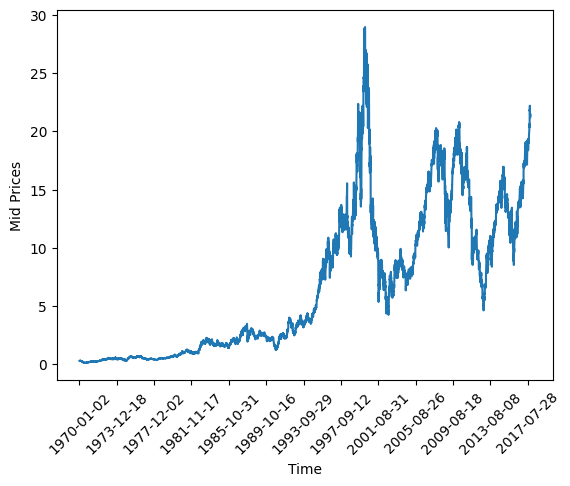

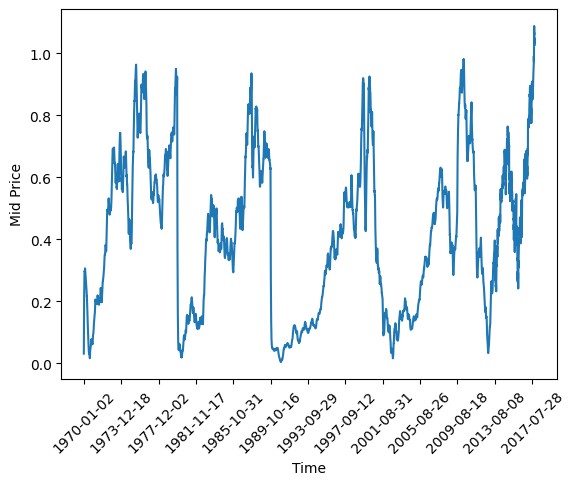

In [6]:
high_prices = stock_df['High'].to_numpy()
low_prices = stock_df['Low'].to_numpy()
mid_prices = (high_prices + low_prices) / 2.0

mid_prices

plot_graph(stock_df['Date'], mid_prices, x_label='Time', y_label='Mid Prices')

train_data = mid_prices[:11000]
test_data = mid_prices[11000:]

scaler = MinMaxScaler()

train_data = train_data.reshape(-1, 1)
test_data = test_data.reshape(-1, 1)

# Min/Max normalize
smoothing_window_size = 2500
smoothing_end = train_data.shape[0] // smoothing_window_size * smoothing_window_size

for di in range(0, smoothing_end, smoothing_window_size):
	scaler.fit(train_data[di:di + smoothing_window_size, :])
	train_data[di:di + smoothing_window_size, :] = scaler.transform(train_data[di:di + smoothing_window_size, :])

scaler.fit(train_data[di + smoothing_window_size:, :])
train_data[di + smoothing_window_size:, :] = scaler.transform(train_data[di + smoothing_window_size:, :])

# Moving average
train_data = train_data.reshape(-1)

test_data = scaler.transform(test_data).reshape(-1)

EMA = 0.0
gamma = 0.1
for ti in range(train_data.shape[0]):
	EMA = gamma * train_data[ti] + (1 - gamma) * EMA
	train_data[ti] = EMA

all_mid_data = np.concatenate([train_data, test_data], axis=0)

plot_graph(stock_df['Date'], all_mid_data, x_label='Time', y_label='Mid Price')

In [94]:

class DataGeneratorSeq(object):

	def __init__(self, prices, batch_size, num_unroll):
		self._prices = prices
		self._prices_length = len(self._prices) - num_unroll
		self._batch_size = batch_size
		self._num_unroll = num_unroll
		self._segments = self._prices_length // self._batch_size
		self._cursor = [offset * self._segments for offset in range(self._batch_size)]

	def next_batch(self):

		batch_data = np.zeros((self._batch_size), dtype=np.float32)
		batch_labels = np.zeros((self._batch_size), dtype=np.float32)

		for b in range(self._batch_size):
			if self._cursor[b] + 1 >= self._prices_length:
				#self._cursor[b] = b * self._segments
				self._cursor[b] = np.random.randint(0, (b + 1) * self._segments)

			batch_data[b] = self._prices[self._cursor[b]]
			batch_labels[b] = self._prices[self._cursor[b] + np.random.randint(0, 5)]

			self._cursor[b] = (self._cursor[b] + 1) % self._prices_length

		return batch_data, batch_labels

	def unroll_batches(self):
		unroll_data, unroll_labels = [], []
		init_data, init_label = None, None
		for ui in range(self._num_unroll):
			data, labels = self.next_batch()
			unroll_data.append(data)
			unroll_labels = labels

		unroll_data = tf.expand_dims(tf.convert_to_tensor(unroll_data), 2)
		unroll_data = tf.transpose(unroll_data, perm=[1, 0, 2])
		unroll_labels = tf.expand_dims(tf.convert_to_tensor(unroll_labels), axis=1)
		return unroll_data, unroll_labels


@tf.function
def reset_indices(self):
	for b in range(self._batch_size):
		self._cursor[b] = np.random.randint(0, min((b + 1) * self._segments, self._prices_length - 1))



In [80]:

dg = DataGeneratorSeq(train_data, 5, 3)
u_data, u_labels = dg.unroll_batches()

u_data.shape, u_labels.shape


(TensorShape([5, 3, 1]), TensorShape([5, 1]))

In [95]:
D = 1  # Dimensionality of the data. Since your data is 1-D this would be 1
num_unrollings = 50  # Number of time steps you look into the future.
batch_size = 500  # Number of samples in a batch
num_nodes = [200, 200, 150]  # Number of hidden nodes in each layer of the deep LSTM stack we're using
n_layers = len(num_nodes)  # number of layers
dropout = 0.2  # dropout amount

tf.compat.v1.reset_default_graph()  # This is important in case you run this multiple times


In [122]:
# Input data.
dg = DataGeneratorSeq(train_data, batch_size, num_unrollings)
train_inputs, train_outputs = dg.unroll_batches()

print(train_inputs.shape)
print(train_outputs.shape)

(500, 50, 1)
(500, 1)


In [125]:
layers = [tf.keras.layers.Input(shape=(train_inputs.shape[1], train_inputs.shape[2])),
		  *[tf.keras.layers.LSTM(
				  num_nodes[layer],
				  return_sequences=(layer < n_layers - 1)
		  ) for layer in range(n_layers)],
		  tf.keras.layers.Dense(1)]

model = tf.keras.Sequential(layers)

model.compile(
		optimizer=tf.keras.optimizers.Adam(),
		loss='mse',
		metrics=['mae']  # Mean Absolute Error as a metric instead of accuracy
)


In [126]:
from tqdm import tqdm

optimizer = tf.keras.optimizers.Adam()
loss_func = tf.keras.losses.MeanSquaredError()

losses = []
accuracies = []
for i in tqdm(range(100)):
	train_inputs, train_outputs = dg.unroll_batches()

	with tf.GradientTape() as tape:
		predictions = model(train_inputs)
		loss = loss_func(train_outputs, predictions)

	# Compute gradients
	gradients = tape.gradient(loss, model.trainable_variables)

	# Apply gradients
	optimizer.apply_gradients(zip(gradients, model.trainable_variables))

	if i % 2 == 0:
		loss, accuracy = model.evaluate(train_inputs, train_outputs, verbose=0)
		losses.append(loss)
		accuracies.append(accuracy)

print(losses)

0.027339771389961243 0.1310465931892395
0.005881989374756813 0.06203031912446022
0.04319320619106293 0.16563279926776886
0.038977254182100296 0.15512694418430328
0.010087530128657818 0.07901103794574738
0.013683291152119637 0.10620933026075363
0.014960152097046375 0.11517702788114548
0.003890671767294407 0.05190591141581535
0.008721483871340752 0.07223036140203476
0.01017371378839016 0.07691310346126556
0.005217103753238916 0.05450477823615074
0.0024507560301572084 0.040564943104982376
0.005136801395565271 0.06155706197023392
0.004214616492390633 0.05318836495280266
0.0017783746588975191 0.027485942468047142
0.002243501367047429 0.03225088492035866
0.002666786080226302 0.03820138797163963
0.0016811012756079435 0.027098361402750015
0.0021055927500128746 0.02404003031551838
0.0015530476812273264 0.028164945542812347
0.0012495819246396422 0.024866502732038498
0.0010617779335007071 0.022890672087669373
0.0015357600059360266 0.02943333052098751
0.001387501717545092 0.02848128229379654
0.000

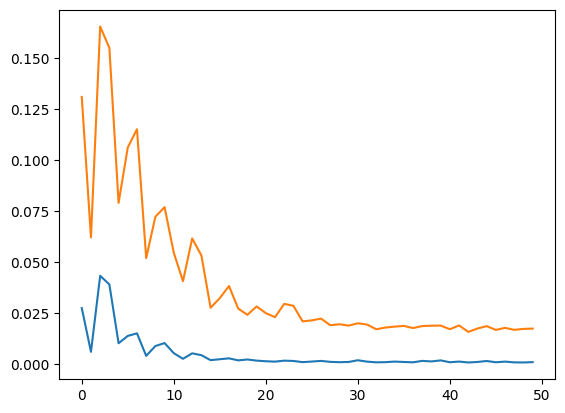

In [127]:
plt.plot(losses, label='mse')
plt.plot(accuracies, label='mae')
plt.show()

In [128]:
def create_stateful_model(original_model, batch_size=1):
	"""Create a stateful version of the trained model for prediction"""

	# Get the input shape from the original model
	input_shape = original_model.input_shape

	# Create stateful layers (note: stateful=True, batch_input_shape instead of shape)
	stateful_layers = [
		tf.keras.layers.Input(batch_shape=(batch_size, input_shape[1], input_shape[2])),
		*[tf.keras.layers.LSTM(
				num_nodes[layer],
				return_sequences=(layer < n_layers - 1),
				stateful=True
		) for layer in range(n_layers)],
		tf.keras.layers.Dense(1)
	]

	stateful_model = tf.keras.Sequential(stateful_layers)

	# Copy weights from the trained model
	stateful_model.set_weights(original_model.get_weights())

	return stateful_model


test_model = create_stateful_model(model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 802ms/step


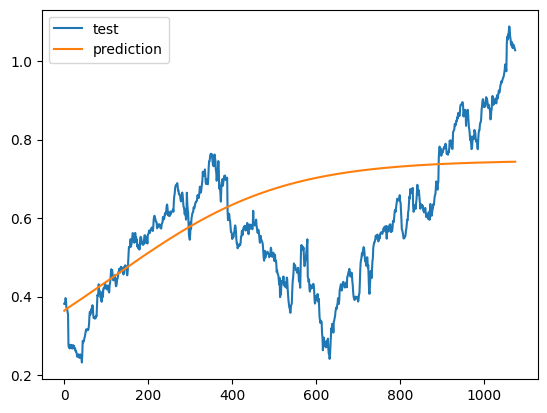

In [129]:
def predict_with_warmup(model, train_inputs, num_to_predict):
	predictions = tf.expand_dims(model.predict(train_inputs), 0)

	future = []
	currentStep = predictions

	for i in range(num_to_predict):
		currentStep = tf.expand_dims(model.predict(currentStep, verbose=False), 0)
		future.append(currentStep)  #store the future steps

	return np.array(future)


prediction = predict_with_warmup(
		test_model,
		tf.expand_dims(tf.expand_dims(tf.constant(train_data), 1), 0),
		len(test_data)
		, ).squeeze()

plt.plot(test_data, label='test')
plt.plot(prediction, label='prediction')
plt.legend()
plt.show()